In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1337)

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Merge, ThresholdedReLU
from keras.layers import Convolution2D, MaxPooling2D, InputLayer
from keras.regularizers import activity_l2
from keras.utils import np_utils
from keras.callbacks import Callback
from keras import backend as K

from ppap.layers import PPAdaptiveMask

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Modified version of keras/examples/mnist_cnn.py

batch_size = 128
nb_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Explicitly set dim ordering to theano
K.set_image_dim_ordering('th')

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


In [4]:
mask = Sequential()
mask.add(PPAdaptiveMask(input_shape[1:], [5, 10, 5], 10,
                        act_reg=activity_l2(0.08), input_shape=input_shape))
mask.add(ThresholdedReLU(theta=0.2))

image_input = Sequential()
image_input.add(InputLayer(input_shape=input_shape))

model = Sequential()
model.add(Merge([mask, image_input], mode='mul'))


model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                        border_mode='valid',
                        input_shape=input_shape))
model.add(Activation('relu'))
# model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=pool_size))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [5]:
def plot_mask(mask_image):
    mean_image = X_test.mean(axis=0)[0]
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(10, 3))
    
    images = [mask_image,
              mean_image,
              np.multiply(mask_image, mean_image)]
    for ax, im in zip(axes, images):
        img = ax.imshow(im) #, vmin=0, vmax=1)

    fig.subplots_adjust(right=0.8)
    cbar = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(img, cax=cbar)
    plt.show()

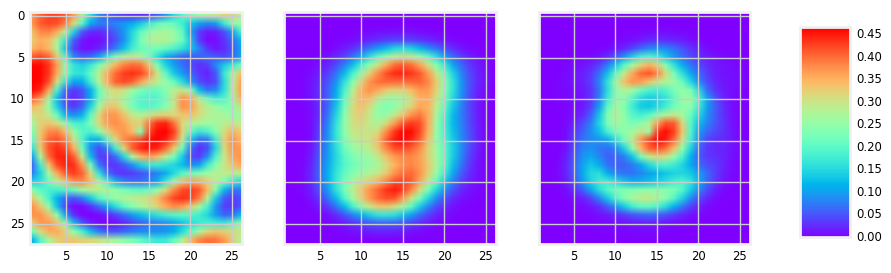

In [6]:
plot_mask(mask.layers[0].mask.eval())

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

class MaskHistory(Callback):
    def on_train_begin(self, logs={}):
        self.masks = []

    def on_batch_end(self, batch, logs={}):
        self.masks.append(mask.layers[0].mask.eval())
        
mask_history = MaskHistory()
        
model.fit([X_train, X_train], Y_train, batch_size=batch_size, nb_epoch=10,
          verbose=1, validation_data=([X_test, X_test], Y_test), callbacks=[mask_history])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 44s - loss: 12.0884 - acc: 0.8798 - val_loss: 0.1711 - val_acc: 0.9492
Epoch 2/10
60000/60000 [==============================] - 46s - loss: 8.4858 - acc: 0.9246 - val_loss: 0.1514 - val_acc: 0.9513
Epoch 3/10
60000/60000 [==============================] - 47s - loss: 6.8893 - acc: 0.9130 - val_loss: 0.1859 - val_acc: 0.9396
Epoch 4/10
60000/60000 [==============================] - 37s - loss: 5.8172 - acc: 0.9130 - val_loss: 0.1855 - val_acc: 0.9418
Epoch 5/10
60000/60000 [==============================] - 37s - loss: 5.3298 - acc: 0.9149 - val_loss: 0.1804 - val_acc: 0.9423
Epoch 6/10
60000/60000 [==============================] - 34s - loss: 5.0094 - acc: 0.9096 - val_loss: 0.1910 - val_acc: 0.9357
Epoch 7/10
60000/60000 [==============================] - 34s - loss: 4.7191 - acc: 0.9076 - val_loss: 0.1929 - val_acc: 0.9380
Epoch 8/10
60000/60000 [=============================

In [8]:
score = model.evaluate([X_test, X_test], Y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9113


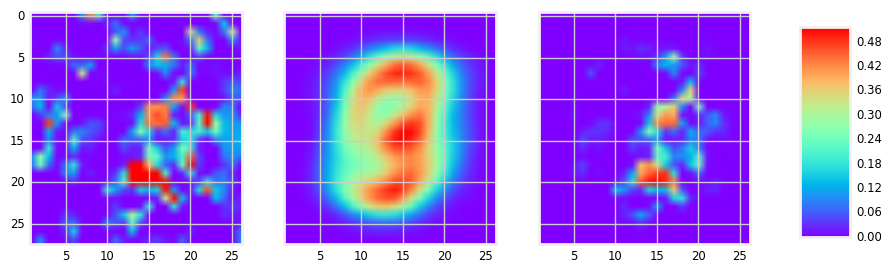

In [9]:
plot_mask(mask_history.masks[-1])

TypeError: Invalid dimensions for image data

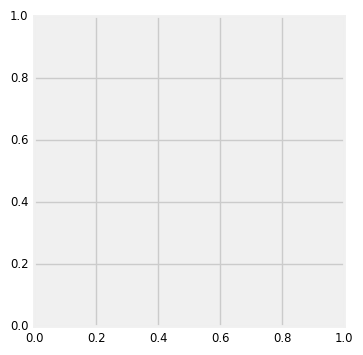

In [24]:
m = mask_history.masks[-1]
m[m < 0.3] = 0
plt.imshow(X_train[0])#np.multiply(X_train.mean(axis=0)[0], m))

file written


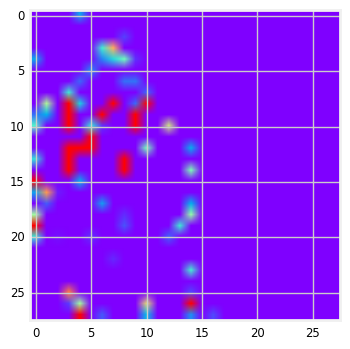

In [15]:
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers["ffmpeg"]
metadata = dict(title="Mask training history", artist="Matplotlib",
                comment="Evolution of mask")
writer = FFMpegWriter(fps=30, metadata=metadata)

fig = plt.figure()
l = plt.imshow(mask_history.masks[0]) #, vmin=0, vmax=1)

with writer.saving(fig, "mask_history.mp4", 100):
    for m in mask_history.masks:
        l.set_data(m)
        writer.grab_frame()
        
print("file written")